In [ ]:
from fastcore.all import *

In [ ]:
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
from datasets import load_from_disk
from tqdm import tqdm
import gc

/home/k/miniconda3/envs/llm_quant/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Compute Scores

In [ ]:
# Load pre-trained model and tokenizer
# model_name = "meta-llama/Meta-Llama-3.1-70B-Instruct"
model_name = "Qwen/Qwen2.5-32B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:17<00:00,  1.03s/it]


In [ ]:
ds = load_from_disk("/home/k/data/qwen_large_mix_dataset_v0_dedup_1536").shuffle(42)

In [ ]:
def calculate_bi_score(model: AutoModelForCausalLM, batch: Dict[str, torch.Tensor]) -> Tuple[List[float], int]:
    "Compute the Block Influence (BI) score components for a single batch."

    # Get all hidden states
    input_shape = batch['input_ids'].shape
    with torch.no_grad(): outputs = model(**batch, output_hidden_states=True)
    hs = [h.to("cpu") for h in outputs.hidden_states]
    del outputs; gc.collect(); torch.cuda.empty_cache()
    
    try:
        sim_total = [0 for _ in range(len(hs)-1)]
        tokens_count = sum(batch['attention_mask'].view(-1)).item()
        for i in range(len(hs) - 1):
            sim = nn.functional.cosine_similarity(hs[i].to("cuda"), hs[i+1].to("cuda"), dim=-1)
            for s,m in zip(sim, batch['attention_mask']):
                sim_total[i] += s[m!=0].sum().cpu().item()

        del sim; gc.collect(); torch.cuda.empty_cache()
        return sim_total, tokens_count

    except Exception as e:
        print(f"ERROR with shape: {input_shape}")
        print(str(e))
        return None

In [ ]:
# test
input_ids = torch.arange(4, device="cuda", dtype=torch.long).view(2,-1)
attn_mask = torch.ones(4, device="cuda", dtype=torch.long).view(2,-1)
b = {"input_ids":input_ids, "attention_mask":attn_mask}
sim_total, tokens_count = calculate_bi_score(model, b)

In [ ]:
bi_scores = 1 - (torch.tensor(sim_total) / tokens_count); bi_scores

tensor([0.8901, 0.1309, 0.0469, 0.0781, 0.2754, 0.0586, 0.0508, 0.0469, 0.0312,
        0.0234, 0.0137, 0.0195, 0.0156, 0.0215, 0.0156, 0.0137, 0.0117, 0.0117,
        0.0078, 0.0098, 0.0078, 0.0078, 0.0059, 0.0078, 0.0078, 0.0078, 0.0078,
        0.0078, 0.0117, 0.0117, 0.0137, 0.0078, 0.0137, 0.0098, 0.0078, 0.0078,
        0.0078, 0.0059, 0.0059, 0.0078, 0.0039, 0.0020, 0.0000, 0.0078, 0.0117,
        0.0078, 0.0117, 0.0078, 0.0098, 0.0117, 0.0176, 0.0156, 0.0117, 0.0117,
        0.0117, 0.0117, 0.0098, 0.0059, 0.0078, 0.0117, 0.0117, 0.0117, 0.0430,
        0.7710])

In [ ]:
all_sim_total, all_tokens_count = [], 0
batch_texts, batch_seqlen = [], 0
for i in tqdm(range(1000)):
    text, token_len = ds[i]['input_text'], ds[i]['token_length']
    if token_len > 1000: print("skip"); continue
    
    batch_texts.append(text)
    batch_seqlen += token_len
    if batch_seqlen > 1000:
        batch = tokenizer(batch_texts, return_tensors="pt", padding=True)
        sim_total, tokens_count = calculate_bi_score(model, batch)
        batch_texts, batch_seqlen = [], 0        
        
        all_sim_total.append(sim_total)
        all_tokens_count += tokens_count
    
        break

  0%|▎                                                                                              | 3/1000 [00:06<37:16,  2.24s/it]


In [ ]:
bi_scores = 1 - (torch.tensor(all_sim_total).sum(0) / all_tokens_count)
scores = list(enumerate(list(bi_scores.numpy())))
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True); sorted_scores[:10]

[(0, 0.88756794),
 (63, 0.48652172),
 (62, 0.08956522),
 (61, 0.061956525),
 (49, 0.053043485),
 (50, 0.05239129),
 (46, 0.052173913),
 (3, 0.051739156),
 (60, 0.049565196),
 (51, 0.049347818)]

### Select Layers

In [ ]:
qwen_2_5_32b_scores = sorted_scores = [(0, 0.88851666),
 (63, 0.50742525),
 (62, 0.080078125),
 (4, 0.074041955),
 (3, 0.06959692),
 (5, 0.059793405),
 (8, 0.05809705),
 (61, 0.052911166),
 (7, 0.049501617),
 (2, 0.04781368),
 (9, 0.044181034),
 (32, 0.043701172),
 (6, 0.043621194),
 (49, 0.04266568),
 (50, 0.041205045),
 (51, 0.040691506),
 (60, 0.040262155),
 (34, 0.039601292),
 (46, 0.03936978),
 (31, 0.039272968),
 (47, 0.03905408),
 (48, 0.038902547),
 (33, 0.038708918),
 (1, 0.03854896),
 (52, 0.03843952),
 (30, 0.03831745),
 (44, 0.03763554),
 (35, 0.036355905),
 (53, 0.03627593),
 (10, 0.036065463),
 (45, 0.03559402),
 (36, 0.034987878),
 (28, 0.0344575),
 (15, 0.03378401),
 (14, 0.033687197),
 (43, 0.033514615),
 (29, 0.033485148),
 (12, 0.033177868),
 (59, 0.033022124),
 (54, 0.032580145),
 (27, 0.032466494),
 (13, 0.032403354),
 (16, 0.0319277),
 (11, 0.031784583),
 (55, 0.031603582),
 (37, 0.03145205),
 (56, 0.030955348),
 (26, 0.030677533),
 (17, 0.030265018),
 (18, 0.030084018),
 (22, 0.03000825),
 (20, 0.029982995),
 (19, 0.029856715),
 (38, 0.029852506),
 (39, 0.029587317),
 (42, 0.029435782),
 (21, 0.029183224),
 (57, 0.028922245),
 (23, 0.02888857),
 (58, 0.028349778),
 (40, 0.027419519),
 (41, 0.026804958),
 (25, 0.026316676),
 (24, 0.026093582)]

In [ ]:
%ai reset

In [ ]:
budget = 0.33
skip_adj = False
top_k = int(len(sorted_scores) * budget)
selected_layers = []
for l_idx, score in sorted_scores:
    if skip_adj and (l_idx-1 in selected_layers or l_idx+1 in selected_layers):
        continue
    if len(selected_layers) < top_k:
        selected_layers.append(l_idx)

print(f"Selected {len(selected_layers)} of {len(sorted_scores)}")
print(",".join(map(str, sorted(selected_layers))))  

Selected 21 of 64
0,2,3,4,5,6,7,8,9,31,32,34,46,47,49,50,51,60,61,62,63


In [ ]:
%%aip 0
Make the above a function.

In [ ]:
def select_layers(sorted_scores, budget=0.33, skip_adj=False):
    top_k = int(len(sorted_scores) * budget)
    selected_layers = []
    for l_idx, score in sorted_scores:
        if skip_adj and (l_idx-1 in selected_layers or l_idx+1 in selected_layers):
            continue
        if len(selected_layers) < top_k:
            selected_layers.append(l_idx)
    
    print(f"Selected {len(selected_layers)} of {len(sorted_scores)}")
    print(",".join(map(str, sorted(selected_layers))))
    
    return selected_layers

# Example usage:
cla2_adj = select_layers(sorted_scores, 0.5)
cla2_no_adj = select_layers(sorted_scores, 0.5, skip_adj=True)
cla3_adj = select_layers(sorted_scores, 0.34)
cla3_no_adj = select_layers(sorted_scores, 0.34, skip_adj=True)

Selected 32 of 64
0,1,2,3,4,5,6,7,8,9,10,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,60,61,62,63
Selected 31 of 64
0,2,4,6,8,10,12,15,17,20,22,24,26,28,30,32,34,36,38,40,42,44,46,49,51,53,55,57,59,61,63
Selected 21 of 64
0,2,3,4,5,6,7,8,9,31,32,34,46,47,49,50,51,60,61,62,63
Selected 21 of 64
0,2,4,6,8,10,12,15,28,30,32,34,36,44,46,49,51,53,59,61,63


In [ ]:
%%aip 0
Modify the function so that if `skip_adj=True`, then it will also use a new parameter called `min_ratio` which doesn't skip adjacent layer if the ratio of score of that layer and the minimum score is > `min_ratio`.

In [ ]:
def select_layers(sorted_scores, budget=0.33, skip_adj=False, min_ratio=1.5):
    top_k = int(len(sorted_scores) * budget)
    selected_layers = []
    min_score = sorted_scores[-1][1]
    for l_idx, score in sorted_scores:
        if skip_adj:
            if l_idx-1 in selected_layers or l_idx+1 in selected_layers:
                if score / min_score <= min_ratio:
                    continue
        if len(selected_layers) < top_k:
            selected_layers.append(l_idx)
    
    print(f"Selected {len(selected_layers)} of {len(sorted_scores)}")
    print(",".join(map(str, sorted(selected_layers))))
    
    return selected_layers

# Test with different min_ratio values
cla2_adj = select_layers(sorted_scores, 0.5)
cla2_no_adj = select_layers(sorted_scores, 0.5, skip_adj=True, min_ratio=1.8)
cla3_adj = select_layers(sorted_scores, 0.34)
cla3_no_adj = select_layers(sorted_scores, 0.34, skip_adj=True, min_ratio=1.8)

Selected 32 of 64
0,1,2,3,4,5,6,7,8,9,10,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,60,61,62,63
Selected 32 of 64
0,2,3,4,5,7,8,10,12,15,17,20,22,26,28,30,32,34,36,38,42,44,46,49,51,53,55,57,59,61,62,63
Selected 21 of 64
0,2,3,4,5,6,7,8,9,31,32,34,46,47,49,50,51,60,61,62,63
Selected 21 of 64
0,2,3,4,5,7,8,10,28,30,32,34,36,44,46,49,51,53,61,62,63


In [ ]:
# Qwen2.5 32b
cla2_adj = "0,1,2,3,4,5,6,7,8,9,10,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,60,61,62,63"
cla2_no_adj = "0,2,3,4,5,7,8,10,12,15,17,20,22,26,28,30,32,34,36,38,42,44,46,49,51,53,55,57,59,61,62,63"
cla3_adj = "0,2,3,4,5,6,7,8,9,31,32,34,46,47,49,50,51,60,61,62,63"
cla3_no_adj = "0,2,3,4,5,7,8,10,28,30,32,34,36,44,46,49,51,53,61,62,63"

### Plot

In [ ]:
def convert_to_chat_input(question):
    messages = [
        {"role": "system", "content": "You are a helpful AI assistant."},
        {"role": "user", "content": question},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [ ]:
# Prepare input
text = """Here is python code to compute the BI score.

```python
def calculate_bi_score(model, input_ids, attention_mask):
    # Get all hidden states
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    
    hidden_states = outputs.hidden_states

    bi_scores = []
    for i in range(len(hidden_states) - 1):
        x_i = hidden_states[i]
        x_i_plus_1 = hidden_states[i + 1]
        
        # Calculate cosine similarity
        similarity = nn.functional.cosine_similarity(x_i.unsqueeze(2), x_i_plus_1.unsqueeze(1), dim=-1)
        
        # Calculate BI score
        bi_score = 1 - similarity.mean().item()
        bi_scores.append(bi_score)
    
    return bi_scores
```
"""

batch = tokenizer(convert_to_chat_input(text), return_tensors="pt")
sim_total, tokens_count = calculate_bi_score(model, batch)

In [ ]:
scores_total = [1-s/tokens_count for s in sim_total]

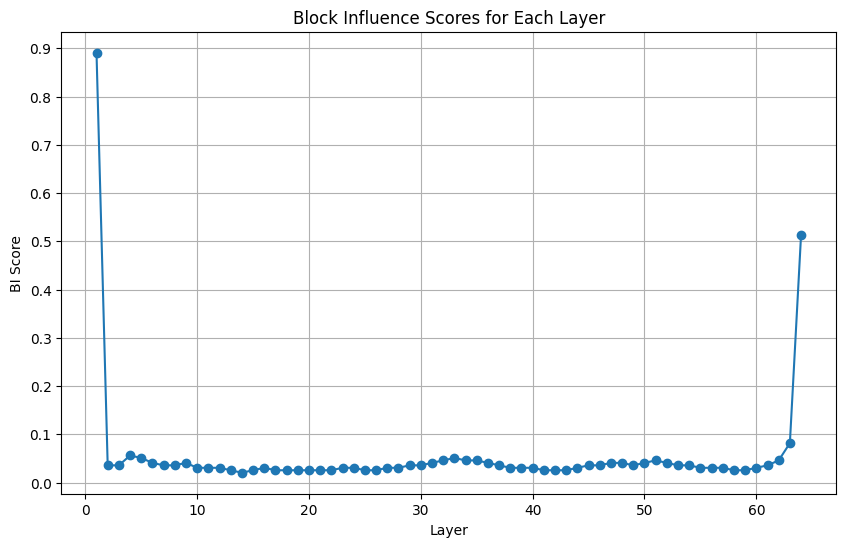

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores_total) + 1), scores_total, marker='o')
plt.title("Block Influence Scores for Each Layer")
plt.xlabel("Layer")
plt.ylabel("BI Score")
plt.grid(True)
plt.yticks(list(np.arange(0,1,0.1)))
plt.show()

### Results

In [ ]:
# llama_3_1_8b_scores =[(0, 0.9580825),
#  (31, 0.92623705),
#  (1, 0.8153315),
#  (2, 0.80458987),
#  (11, 0.80011815),
#  (7, 0.79400295),
#  (8, 0.79155374),
#  (9, 0.7888252),
#  (10, 0.787708),
#  (12, 0.78395313),
#  (6, 0.7835098),
#  (3, 0.7756592),
#  (4, 0.7750059),
#  (5, 0.77466995),
#  (30, 0.7636904),
#  (14, 0.7552764),
#  (13, 0.75454295),
#  (15, 0.751751),
#  (22, 0.7497519),
#  (23, 0.74807227),
#  (21, 0.74428517),
#  (24, 0.741667),
#  (25, 0.73850685),
#  (29, 0.73773825),
#  (16, 0.7371719),
#  (17, 0.73509866),
#  (26, 0.7345957),
#  (20, 0.73239255),
#  (18, 0.732166),
#  (27, 0.72729003),
#  (19, 0.72527736),
#  (28, 0.7247871)]

# llama_3_1_70b_scores = [(0, 0.978506),
#  (79, 0.91416454),
#  (19, 0.8285857),
#  (20, 0.8226407),
#  (18, 0.8223146),
#  (17, 0.81696045),
#  (21, 0.81509286),
#  (22, 0.8083229),
#  (23, 0.80442375),
#  (16, 0.8007189),
#  (24, 0.7973383),
#  (26, 0.7971922),
#  (29, 0.7965952),
#  (78, 0.7950787),
#  (25, 0.7948524),
#  (30, 0.79155916),
#  (27, 0.79107267),
#  (15, 0.7897967),
#  (28, 0.7891356),
#  (31, 0.7869454),
#  (14, 0.7855198),
#  (32, 0.78331006),
#  (56, 0.7714719),
#  (55, 0.7707395),
#  (68, 0.77016747),
#  (33, 0.7700908),
#  (57, 0.7693299),
#  (67, 0.7690697),
#  (13, 0.7684531),
#  (71, 0.7676334),
#  (59, 0.7674676),
#  (72, 0.76705956),
#  (54, 0.76704353),
#  (58, 0.7669811),
#  (47, 0.76684034),
#  (53, 0.7666853),
#  (70, 0.7666158),
#  (52, 0.76642513),
#  (48, 0.7659957),
#  (40, 0.76586026),
#  (60, 0.76554656),
#  (36, 0.7654147),
#  (63, 0.76476604),
#  (51, 0.7642671),
#  (44, 0.76409954),
#  (50, 0.7630339),
#  (64, 0.7627203),
#  (41, 0.7626258),
#  (49, 0.7623532),
#  (69, 0.7623104),
#  (66, 0.7621464),
#  (43, 0.7616671),
#  (45, 0.76109684),
#  (73, 0.7605747),
#  (46, 0.7604856),
#  (42, 0.7604214),
#  (39, 0.7596355),
#  (61, 0.7583471),
#  (62, 0.75832576),
#  (37, 0.7581974),
#  (34, 0.7577875),
#  (35, 0.7577662),
#  (74, 0.7573278),
#  (65, 0.757285),
#  (75, 0.75446403),
#  (77, 0.7530562),
#  (38, 0.7529564),
#  (76, 0.752322),
#  (12, 0.7487615),
#  (10, 0.7456197),
#  (11, 0.7439856),
#  (9, 0.7293532),
#  (7, 0.71686816),
#  (6, 0.7095315),
#  (8, 0.6997427),
#  (5, 0.6873806),
#  (3, 0.67287296),
#  (4, 0.6410384),
#  (2, 0.62671435),
#  (1, 0.6213183)]

In [ ]:
qwen_2_5_32b_scores = [(0, 0.88851666),
 (63, 0.50742525),
 (62, 0.080078125),
 (4, 0.074041955),
 (3, 0.06959692),
 (5, 0.059793405),
 (8, 0.05809705),
 (61, 0.052911166),
 (7, 0.049501617),
 (2, 0.04781368),
 (9, 0.044181034),
 (32, 0.043701172),
 (6, 0.043621194),
 (49, 0.04266568),
 (50, 0.041205045),
 (51, 0.040691506),
 (60, 0.040262155),
 (34, 0.039601292),
 (46, 0.03936978),
 (31, 0.039272968),
 (47, 0.03905408),
 (48, 0.038902547),
 (33, 0.038708918),
 (1, 0.03854896),
 (52, 0.03843952),
 (30, 0.03831745),
 (44, 0.03763554),
 (35, 0.036355905),
 (53, 0.03627593),
 (10, 0.036065463),
 (45, 0.03559402),
 (36, 0.034987878),
 (28, 0.0344575),
 (15, 0.03378401),
 (14, 0.033687197),
 (43, 0.033514615),
 (29, 0.033485148),
 (12, 0.033177868),
 (59, 0.033022124),
 (54, 0.032580145),
 (27, 0.032466494),
 (13, 0.032403354),
 (16, 0.0319277),
 (11, 0.031784583),
 (55, 0.031603582),
 (37, 0.03145205),
 (56, 0.030955348),
 (26, 0.030677533),
 (17, 0.030265018),
 (18, 0.030084018),
 (22, 0.03000825),
 (20, 0.029982995),
 (19, 0.029856715),
 (38, 0.029852506),
 (39, 0.029587317),
 (42, 0.029435782),
 (21, 0.029183224),
 (57, 0.028922245),
 (23, 0.02888857),
 (58, 0.028349778),
 (40, 0.027419519),
 (41, 0.026804958),
 (25, 0.026316676),
 (24, 0.026093582)]

In [ ]:
np.array(sorted([i[0] for i in qwen_2_5_32b_scores[:64//2]]))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 30, 31, 32, 33, 34, 35,
       36, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 60, 61, 62, 63])

In [ ]:
np.array(sorted([i[0] for i in qwen_2_5_32b_scores[:64//3]]))

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 31, 32, 34, 46, 47, 49, 50, 51,
       60, 61, 62, 63])